
Load Dataset


In [ ]:
model.save("diabetes_cnn_model.keras")


In [ ]:
from google.colab import files
files.download("diabetes_cnn_model.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib
joblib.dump(scaler, "scaler.save")
files.download("scaler.save")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving diabetes.csv to diabetes.csv


Setup & Installations


In [ ]:
!pip install scikit-learn tensorflow pandas numpy imbalanced-learn matplotlib seaborn

Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from imblearn.over_sampling import SMOTE

Load Dataset

In [ ]:
# Upload dataset manually or replace path accordingly
df = pd.read_csv('diabetes.csv')

print("Dataset loaded successfully!")
df.head()

Dataset loaded successfully!


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Data Preprocessing

In [ ]:
# Columns that shouldn't have zero values
zero_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Replace zeros with NaN then fill with median
for col in zero_columns:
    df[col] = df[col].replace(0, np.nan)
    mean = df[col].mean()
    df[col].fillna(mean, inplace=True)

print("Missing values replaced with median.")

Missing values replaced with median.


<ipython-input-6-da159d82e03d>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mean, inplace=True)


Normalize Features

In [ ]:
scaler = MinMaxScaler()
X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_scaled = scaler.fit_transform(X)

print("Features normalized between [0,1].")

Features normalized between [0,1].


Handle Class Imbalance using SMOTE

In [ ]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

print(f"Class distribution before SMOTE:\n{y.value_counts()}")
print(f"\nClass distribution after SMOTE:\n{y_res.value_counts()}")

Class distribution before SMOTE:
Outcome
0    500
1    268
Name: count, dtype: int64

Class distribution after SMOTE:
Outcome
1    500
0    500
Name: count, dtype: int64


 Split into Train and Test Sets


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42, stratify=y_res)

# Reshape data for 1D-CNN input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("Train/Test split completed. Data reshaped for 1D-CNN.")

Train/Test split completed. Data reshaped for 1D-CNN.


Build 1D-CNN Model

In [ ]:
def build_model(input_shape):
    model = Sequential()

    # Layer 1
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    # Layer 2
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

input_shape = (X_train.shape[1], 1)
model = build_model(input_shape)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 8, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 4, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,473 (162.00 KB)

 Trainable params: 41,473 (162.00 KB)

 Non-trainable params: 0 (0.00 B)

Train the Model

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5039 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6852
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5239 - loss: 0.6790 - val_accuracy: 0.5000 - val_loss: 0.6793
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5152 - loss: 0.6837 - val_accuracy: 0.5429 - val_loss: 0.6700
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5890 - loss: 0.6651 - val_accuracy: 0.7000 - val_loss: 0.6484
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6278 - loss: 0.6551 - val_accuracy: 0.6714 - val_loss: 0.6220
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6672 - loss: 0.6292 - val_accuracy: 0.7429 - val_loss: 0.5785
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6977 - loss: 0.5985 - val_accuracy: 0.7500 - val_loss: 0.5545
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7401 - loss: 0.5656 - val_accuracy: 0.7500 - val

Evaluate the Model

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.8267
Precision: 0.7849
Recall: 0.9000
F1 Score: 0.8385


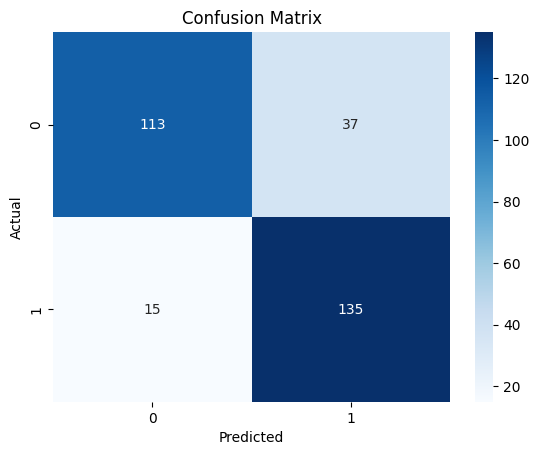


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.75      0.81       150
           1       0.78      0.90      0.84       150

    accuracy                           0.83       300
   macro avg       0.83      0.83      0.83       300
weighted avg       0.83      0.83      0.83       300



In [ ]:
# Predict
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Compare with Traditional ML Models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "Naive Bayes": GaussianNB()
}

results = []

for name, model_ml in models.items():
    model_ml.fit(X_train.reshape(-1, 8), y_train)
    y_pred_ml = model_ml.predict(X_test.reshape(-1, 8))
    acc_ml = accuracy_score(y_test, y_pred_ml)
    prec_ml = precision_score(y_test, y_pred_ml)
    rec_ml = recall_score(y_test, y_pred_ml)
    f1_ml = f1_score(y_test, y_pred_ml)
    results.append([name, acc_ml, prec_ml, rec_ml, f1_ml])

# Print comparison
print("\nModel Comparison:")
comparison_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])
print(comparison_df.to_string(index=False))


Model Comparison:
              Model  Accuracy  Precision   Recall  F1-Score
Logistic Regression  0.760000   0.774648 0.733333  0.753425
      Decision Tree  0.783333   0.781457 0.786667  0.784053
      Random Forest  0.840000   0.807229 0.893333  0.848101
                SVM  0.830000   0.796407 0.886667  0.839117
        Naive Bayes  0.710000   0.736842 0.653333  0.692580
